<a href="https://colab.research.google.com/github/calebtham/reinforcement-learning/blob/main/ddpg_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Deterministic Policy Gradient (DDPG)

### Original notebook:

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/rl/ipynb/ddpg_pendulum.ipynb

**Author:** [amifunny](https://github.com/amifunny)<br>
**Date created:** 2020/06/04<br>
**Last modified:** 2020/09/21<br>
**Description:** Implementing DDPG algorithm on the Inverted Pendulum Problem.

### Modified by:

**Author:** Caleb<br>
**Last modified:** 2023/11<br>


## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
   given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.


In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.


In [2]:
problem = "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))

num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise, as described in the paper.
It samples noise from a correlated normal distribution.


In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) *
            np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

# Implementing the DDPG algorithm

---

## ![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)

**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.


In [9]:
class DDPG:

    def __init__(self, buffer_capacity=100000, batch_size=64, actor_lr=0.001,
                 critic_lr=0.002, std_dev=0.2, gamma=0.99, tau=0.005):

        # Hyperparameters
        self.ou_noise = OUActionNoise(
            mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
        self.gamma = gamma
        self.tau = tau

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity

        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

        # Actor critic models
        self.actor_model = self._init_actor()
        self.critic_model = self._init_critic()

        # Actor critic target models
        self.target_actor = self._init_actor()
        self.target_actor.set_weights(self.actor_model.get_weights())

        self.target_critic = self._init_critic()
        self.target_critic.set_weights(self.critic_model.get_weights())

        # Optimisers
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)

        # To store reward history of each episode
        self.ep_reward_list = []

        # To store average reward history of last few episodes
        self.avg_reward_list = []

    def get_models(self):
        """Returns actor_model, critic_model, target_actor, target_critic."""
        return self.actor_model, self.critic_model, self.target_actor, self.target_critic

    def save(self, name="checkpoint", path='.'):
        """Save model weights."""

        if path[-1] == '/':
            path = path[:-1]

        self.actor_model.save_weights(f"{path}/{name}_actor.h5")
        self.critic_model.save_weights(f"{path}/{name}_critic.h5")

        self.target_actor.save_weights(f"{path}/{name}_target_actor.h5")
        self.target_critic.save_weights(f"{path}/{name}_target_critic.h5")

    def load(self, name="checkpoint", path='.'):
        """Load model weights."""

        if path[-1] == '/':
            path = path[:-1]

        self.actor_model.load_weights(f"{path}/{name}_actor.h5")
        self.critic_model.load_weights(f"{path}/{name}_critic.h5")

        self.target_actor.load_weights(f"{path}/{name}_target_actor.h5")
        self.target_critic.load_weights(f"{path}/{name}_target_critic.h5")

    def train(self, total_episodes=100):
        """Main train loop to train the model for given number of episodes.
        We sample actions using `policy()` and train with `_learn()` at each time step,
        along with updating the Target networks at a rate `tau`."""

        # Takes about 4 min to train
        for ep in range(total_episodes):

            prev_state = env.reset()
            episodic_reward = 0

            while True:
                # Uncomment this to see the Actor in action
                # But not in a python notebook.
                # env.render()

                tf_prev_state = tf.expand_dims(
                    tf.convert_to_tensor(prev_state), 0)

                action = self.policy(tf_prev_state, add_noise=True)

                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)

                self._record((prev_state, action, reward, state))
                episodic_reward += reward

                self._learn()
                self.update_target(self.target_actor.variables, self.actor_model.variables)
                self.update_target(self.target_critic.variables, self.critic_model.variables)

                # End this episode when `done` is True
                if done:
                    break

                prev_state = state

            self.ep_reward_list.append(episodic_reward)

            # Mean of last 40 episodes
            avg_reward = np.mean(self.ep_reward_list[-40:])
            print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
            self.avg_reward_list.append(avg_reward)

        return self.ep_reward_list, self.avg_reward_list

    def policy(self, state, add_noise=False):
        """Returns an action sampled from our Actor network.
        Noise can be added for exploration when training."""

        sampled_actions = tf.squeeze(self.actor_model(state))

        # Adding noise to action
        noise = self.ou_noise() if add_noise else 0
        sampled_actions = sampled_actions.numpy() + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

        return [np.squeeze(legal_action)]

    def _init_actor(self):
        """Defines actor model. Takes input from environment (state) and outputs an action."""

        # Initialize weights between -3e-3 and 3-e3:
        # We need the initialization for last layer of the Actor to be
        # between `-0.003` and `0.003` as this prevents us from getting `1` or `-1`
        # output values in the initial stages, which would squash our gradients to
        # zero, as we use the `tanh` activation.
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

        inputs = layers.Input(shape=(num_states,))
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1, activation="tanh",
                               kernel_initializer=last_init)(out)

        # Our upper bound is 2.0 for Pendulum.
        outputs = outputs * upper_bound
        model = tf.keras.Model(inputs, outputs)

        return model

    def _init_critic(self):
        """Defines critic model.
        Takes state and action as input, and outputs a single value (-bad, +good)."""

        # State as input
        state_input = layers.Input(shape=(num_states))
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.Dense(32, activation="relu")(state_out)

        # Action as input
        action_input = layers.Input(shape=(num_actions))
        action_out = layers.Dense(32, activation="relu")(action_input)

        # Both are passed through seperate layer before concatenating
        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(256, activation="relu")(concat)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1)(out)

        # Outputs single value for give state-action
        model = tf.keras.Model([state_input, action_input], outputs)

        return model

    def _record(self, obs_tuple):
        """Takes (s,a,r,s') observation tuple as input and records it in the buffer."""

        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function. This
    # provides a large speed up for blocks of code that contain many small TensorFlow operations
    # such as this one.
    @tf.function
    def update_target(self, target_weights, weights):
        """Updates target parameters slowly. Based on rate `tau`, which is much less than one."""
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function. This
    # provides a large speed up for blocks of code that contain many small TensorFlow operations
    # such as this one.
    @tf.function
    def _update(self, state_batch, action_batch, reward_batch, next_state_batch):
        """Compute the loss and update parameters based on a batch of (s, a, r, s') tuples."""

        # Critic loss
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model(
                [state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        # Update critic
        critic_grad = tape.gradient(
            critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        # Actor loss
        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model(
                [state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        # Update actor
        actor_grad = tape.gradient(
            actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    def _learn(self):
        """Wrapper for update function to randomly sample buffer and convert
        sample to tensors (batches). The batches are input to the update function."""

        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)

        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(
            self.next_state_buffer[batch_indices])

        self._update(state_batch, action_batch, reward_batch, next_state_batch)

### TODO:

- We define the Actor and Critic networks as basic Dense models with `ReLU` activation. We will want to change this model for our application, especially the input and output layers.

- We need define what states and actions should look like. Currently, `env.step(action)` gives state, reward, done, and info (info is currently not being used). We need to define our own analagous step function.
    - Define the model inputs (states)
    - Define the model outputs (actions)
    - Define the rewards
    - Define when an episode is 'done'


In [5]:
ddpg_model = DDPG()

In [6]:
ep_reward_list, avg_reward_list = ddpg_model.train()

Episode * 0 * Avg Reward is ==> -1325.9169826863508
Episode * 1 * Avg Reward is ==> -1157.0120663770467
Episode * 2 * Avg Reward is ==> -1311.6539312548746
Episode * 3 * Avg Reward is ==> -1364.5161969631738
Episode * 4 * Avg Reward is ==> -1385.0820381420276
Episode * 5 * Avg Reward is ==> -1386.0628120622941
Episode * 6 * Avg Reward is ==> -1372.313294174421
Episode * 7 * Avg Reward is ==> -1342.4948860699499
Episode * 8 * Avg Reward is ==> -1321.975415302277
Episode * 9 * Avg Reward is ==> -1293.4948767301198
Episode * 10 * Avg Reward is ==> -1313.5126127657625
Episode * 11 * Avg Reward is ==> -1304.003727039726
Episode * 12 * Avg Reward is ==> -1295.925118281217
Episode * 13 * Avg Reward is ==> -1269.777340430779
Episode * 14 * Avg Reward is ==> -1254.9148558891393
Episode * 15 * Avg Reward is ==> -1250.6469707802512
Episode * 16 * Avg Reward is ==> -1223.5172371668332
Episode * 17 * Avg Reward is ==> -1198.0244589630229
Episode * 18 * Avg Reward is ==> -1155.8417486796961
Episode 

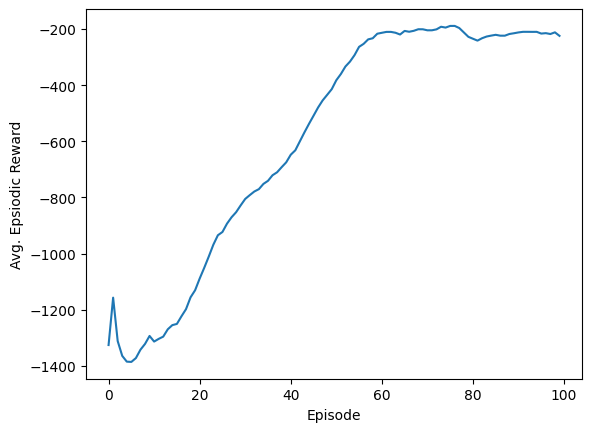

In [7]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ddpg_model.avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other
problems.

Another great environment to try this on is `LunarLandingContinuous-v2`, but it will take
more episodes to obtain good results.


In [8]:
# Save the weights
ddpg_model.save()